In [1]:
import sys
sys.path.insert(0, '../utils/')

from sklearn.decomposition import PCA, KernelPCA
from sklearn import cluster, metrics, mixture
from scipy.spatial.distance import cdist
from dictionaries_rename import (
    get_binary_names,
    get_dummies_names,
    get_ordinal_names,
    opinion_questions,
)

from utils_clustering import save_fig, plot_optimal_k
from itertools import repeat
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Loading the prepared (for clustering) data

In [2]:
%run Prepare_clustering_data.ipynb

The number of people who answered one of the check questions incorrectly is 1207.


# Metrics

Unsupervised learning is not so easy. How do we know that our clustering makes sense? These are some possible metrics to compare unsupervised learning methods.

* Silhouette score $[-1; 1]$, the closer to 1 - the better;
* Calinski-Harabasz score $[0; \infty]$, the larger - the better;
* Davies Bouldin score $[0, 1]$, the closer to 0 - the better.

In [3]:
class ClusterScores():
    """Computes and stores quality measures for different clustering"""

    def __init__(self):
        self.df = pd.DataFrame()

    def compute(self, X, labels):
        """computes quality measures"""
        silhouette = metrics.silhouette_score(X, labels)
        calinski_harabasz = metrics.calinski_harabasz_score(X, labels)
        davies = metrics.davies_bouldin_score(X, labels)
        self.df = self.df.append({'silhouette': silhouette,
                                  'calinski': calinski_harabasz,
                                  'davies': davies}, ignore_index=True)

# Compare Methods

Lets compare standard methods according to the above scores. 
Spoiler alert: *Kmeans* performed the best.

## Investigate performance

Since we do not know what type of clustering method would be most appropriate for our data, we just run a couple of standard algorithms and see how they behave according to the above mentioned metrics.

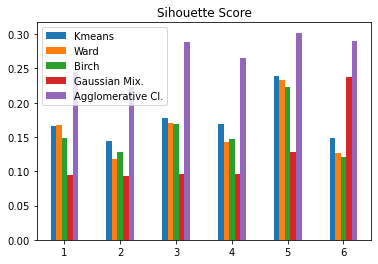

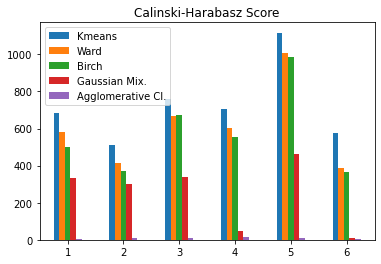

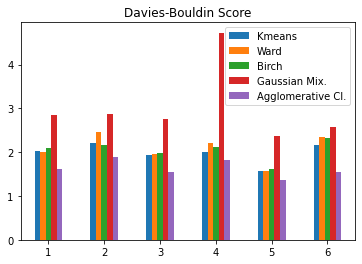

In [4]:
all_waves_metrics = pd.DataFrame()
for w in waves:
    cluster_scores = ClusterScores()

    kmeans = cluster.KMeans(n_clusters=2).fit(df_opinion[w])
    cluster_scores.compute(df_opinion[w], kmeans.labels_)

    ward = cluster.AgglomerativeClustering(
        n_clusters=2, linkage="ward").fit(df_opinion[w])
    cluster_scores.compute(df_opinion[w], ward.labels_)

    birch = cluster.Birch(n_clusters=2).fit(df_opinion[w])
    cluster_scores.compute(df_opinion[w], birch.labels_)

    gmm = mixture.GaussianMixture(
        n_components=2, covariance_type='full').fit(df_opinion[w])
    cluster_scores.compute(df_opinion[w], gmm.predict(df_opinion[w]))

    average_linkage = cluster.AgglomerativeClustering(
        n_clusters=2, linkage="average", affinity="cityblock").fit(df_opinion[w])
    cluster_scores.compute(df_opinion[w], average_linkage.labels_)

    cluster_scores.df.index = ['Kmeans', 'Ward',
                               'Birch', 'Gaussian Mix.', 'Agglomerative Cl.']
    all_waves_metrics = pd.concat(
        [all_waves_metrics, cluster_scores.df], axis=1)

    #S_clustering = SpectralClustering(n_clusters=2).fit(X_agreement)
    #S_clustering_labels = S_clustering.labels_
    #cluster_scores(X_agreement, S_clustering_labels)

    #plot_metrics(calinski, wave, 3, 'calinski_harabasz_score')
    #plot_metrics(davies, wave, 2, 'davies_bouldin_score')
    #plot_metrics(silhouette, wave, 1, 'silhouette_score')

wave_list = pd.DataFrame([x for wave in waves for x in repeat(wave, 3)])
wave_list.index = all_waves_metrics.columns
wave_list.columns = ['wave']
all_waves_metrics = pd.concat([all_waves_metrics.T, wave_list], axis=1)
metrics_list = ['silhouette', 'calinski', 'davies']
title_list = ['Sihouette Score',
              'Calinski-Harabasz Score', 'Davies-Bouldin Score']
for metric, title in zip(metrics_list, title_list):
    (all_waves_metrics
        .filter(like=metric, axis=0)
        .plot.bar(title=title, rot=0)
        .set_xticklabels(waves)
     )
    save_fig(title)

K-means performed either best or second best across the different metric. *Agglomerative clustering* is the best performing method with respect to *Silhouette score* and the *Davies-Bouldin score*, but the worst with respect to the *Calinski-Harabasz score*, which might be worth investigating. (Spectral clustering took too long so it was not applied). In conclusion we use K-means for all of our next step.

## Defining optimal number of clusters

### Elbow method

In the Elbow method, we are actually varying the number of clusters ($k$) from 1 to 5. For each value of k, we are calculating WCSS (Within-Cluster Sum of Square). WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS as a function of the number of clusters, as the number of clusters increases, the WCSS value will naturally decrease. In particular the WCSS value is largest when $k$ = 1. When we look the graph we can see that the function will rapidly decrease initially, but at some piont the rate of decrease should be slowed down: creating an elbow shape. The number of clusters at which this change occurs is typically considered as the optimal number of clusters.

In [5]:
distortions_df = []
inertias_df = []
for w in waves:
    distortions = []
    inertias = []
    for k in range(1, 9):
        kmeanModel = cluster.KMeans(n_clusters=k).fit(df_opinion[w])
        distortions.append(sum(np.min(
            cdist(df_opinion[w], kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_opinion[w].shape[0])
        inertias.append(kmeanModel.inertia_)
    distortions_df.append(distortions)
    inertias_df.append(inertias)
distortions_df = pd.DataFrame(
    distortions_df, index=waves, columns=list(range(1, 9))).T
inertias_df = pd.DataFrame(inertias_df, index=waves,
                           columns=list(range(1, 9))).T

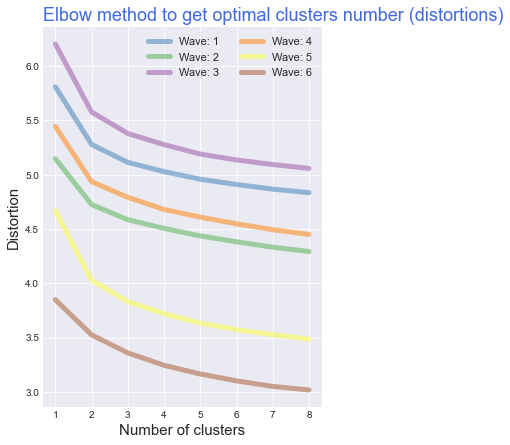

In [6]:
plot_optimal_k(distortions_df, list(range(
    1, 9)), "Elbow method to get optimal clusters number (distortions)", "Number of clusters", "Distortion")

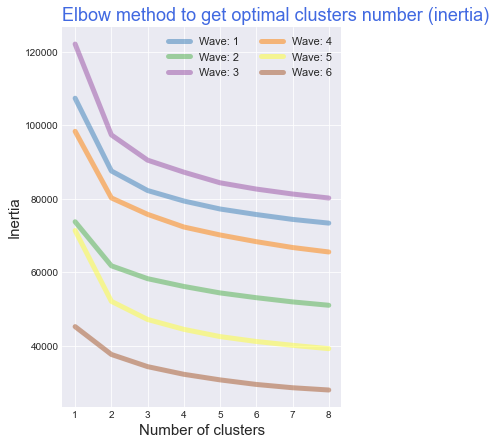

In [7]:
plot_optimal_k(inertias_df, list(range(
    1, 9)), "Elbow method to get optimal clusters number (inertia)", "Number of clusters", "Inertia")

<center><b>The optimal number of clusters seems to be $2$.</b></center>
However, for some waves it is not as clear. Like wave 6.

Let's look also a the Silhouette Score to be sure.

### Silhouette Score

Silhouette score: $\frac{b_i-a_i}{max(b_i, a_i)}$

The Silhouette score is used to measure the degree of separation between clusters. In the formula above $b_i$ represents the shortest mean distance between a point to all points in any other cluster of which $i$ is not a part, whereas $a_i$ is the mean distance of $i$ and all data points from the same cluster. Logically if $b_i$ > $a_i$, then a point is well separated from its neighboring cluster whereas it is closer to all points from the cluster it belongs to. 

Recall that **larger means better**.

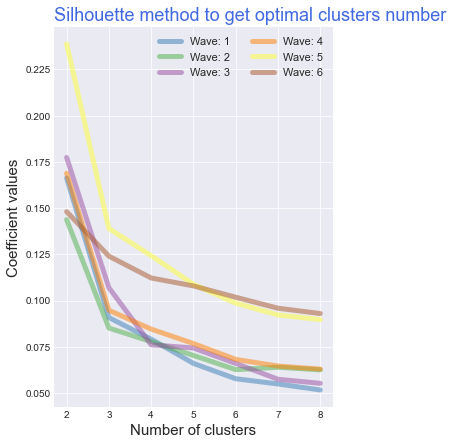

In [8]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
silhouette_df = []
for w in waves:
    wave_silhouette_df = []
    for n_clusters in range(2, 9):
        clusterer = cluster.KMeans(n_clusters=n_clusters)
        preds = clusterer.fit_predict(df_opinion[w])
        centers = clusterer.cluster_centers_
        score = metrics.silhouette_score(df_opinion[w], preds)
        wave_silhouette_df.append(score)
    silhouette_df.append(wave_silhouette_df)
silhouette_df = pd.DataFrame(
    silhouette_df, index=waves, columns=list(range(2, 9))).T

plot_optimal_k(silhouette_df, list(range(
    2, 9)), "Silhouette method to get optimal clusters number", "Number of clusters", "Coefficient values")

The closer to 1 - the better. All values are quite low, but for 2 clusters we can see the highest ones.

<center><b> Silhuette score also suggests 2 clusters. </b></center>

In [9]:
# convert this notebook to pdf but without the code
#!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True --output-dir=output_pdf clustering.ipynb